Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 3)      84          input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 3)      84          lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 3)      84          lstm_1[0][0]                     
_______________________________________________________________________________________

1/1 [==============================] - 0s 48ms/step - loss: 0.1544
Epoch 177/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1535
Epoch 178/500
1/1 [==============================] - 0s 46ms/step - loss: 0.1525
Epoch 179/500
1/1 [==============================] - 0s 47ms/step - loss: 0.1515
Epoch 180/500
1/1 [==============================] - 0s 47ms/step - loss: 0.1506
Epoch 181/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1498
Epoch 182/500
1/1 [==============================] - 0s 47ms/step - loss: 0.1490
Epoch 183/500
1/1 [==============================] - 0s 47ms/step - loss: 0.1482
Epoch 184/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1475
Epoch 185/500
1/1 [==============================] - 0s 47ms/step - loss: 0.1468
Epoch 186/500
1/1 [==============================] - 0s 47ms/step - loss: 0.1463
Epoch 187/500
1/1 [==============================] - 0s 47ms/step - loss: 0.1456
Epoch 188/500
1/1 [=======================

1/1 [==============================] - 0s 73ms/step - loss: 0.2315
Epoch 379/500
1/1 [==============================] - 0s 85ms/step - loss: 0.2178
Epoch 380/500
1/1 [==============================] - 0s 73ms/step - loss: 0.1983
Epoch 381/500
1/1 [==============================] - 0s 84ms/step - loss: 0.1817
Epoch 382/500
1/1 [==============================] - 0s 84ms/step - loss: 0.1660
Epoch 383/500
1/1 [==============================] - 0s 84ms/step - loss: 0.1844
Epoch 384/500
1/1 [==============================] - 0s 87ms/step - loss: 0.1819
Epoch 385/500
1/1 [==============================] - 0s 83ms/step - loss: 0.2037
Epoch 386/500
1/1 [==============================] - 0s 84ms/step - loss: 0.2136
Epoch 387/500
1/1 [==============================] - 0s 84ms/step - loss: 0.2175
Epoch 388/500
1/1 [==============================] - 0s 84ms/step - loss: 0.2143
Epoch 389/500
1/1 [==============================] - 0s 86ms/step - loss: 0.2057
Epoch 390/500
1/1 [=======================

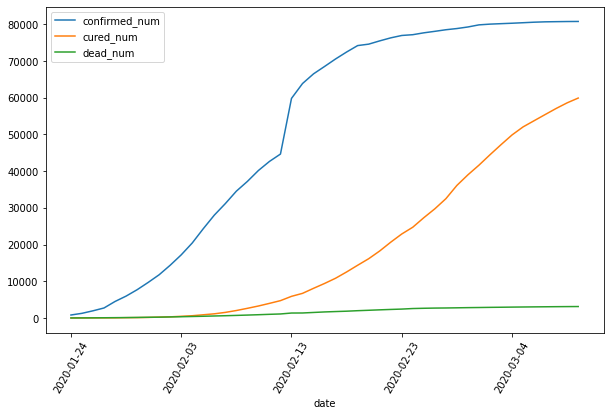

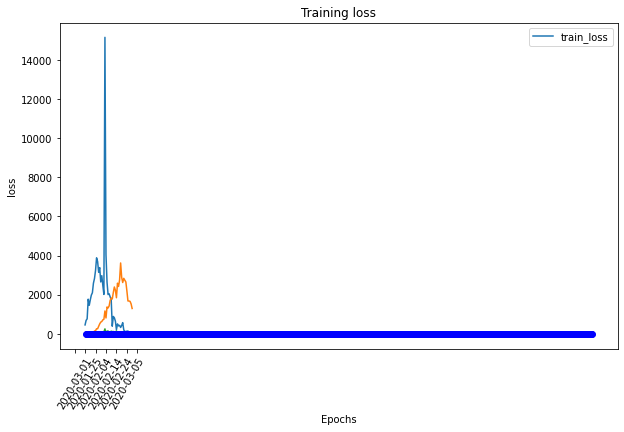

,confirmed_num,cured_num,dead_num
62,0.0,36.0,0.0
63,0.0,29.0,0.0
64,0.0,23.0,0.0
65,0.0,18.0,0.0
66,0.0,14.0,0.0


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks
import os
import datetime

# 加载数据
df = pd.read_csv("./datasets/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")
dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)
ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

# 构建模型
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

tf.keras.backend.clear_session()

x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

# 训练
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('logs', 'autograph', stamp)
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]
history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

# 评估
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

plot_metric(history,"loss")

# 使用
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))
    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)
dfresult.query("confirmed_num==0").head()
dfresult.query("cured_num==0").head()
dfresult.query("dead_num==0").head()
